In [83]:
import numpy as np
import pyarrow as pa
import pandas as pd
pd.options.mode.copy_on_write = True

import matplotlib.pyplot as plt

import pyNUISANCE as pn

Load in some NuWro Events to play with

In [2]:
gevs = pn.EventSource("../q0q3plots/NuWro.numu.numu_flux.flux_dune_neutrino_ND.1203.evts.root")
gri = gevs.run_info()

# Analysis Projections

In [3]:
from pyProSelecta import event, part, unit, pdg, energy, kinetic_energy
from pyNuHepMC import EventUtils
from pyHepMC3.pyHepMC3.HepMC3 import FourVector

def invariant_hadronic_mass(ev):
    # get the hard scatter vertex
    pv = EventUtils.GetPrimaryVertex(ev)
    p4 = FourVector(0,0,0,0)
    # sum all non lepton out-going particles
    for p in pv.particles_out():
        pid_abs = abs(p.pid())
        if (pid_abs > 16) and (pid_abs < 1000000000):
            p4 = p4 + p.momentum()
    return p4.m() / unit.GeV_c2

def EHadAv_Mnv(ev):
    erec = 0
    for fsp in event.all_out_part(ev):
        pid = fsp.pid()

        if abs(pid) == 13:
            continue
        elif pid == 2112:
            continue
        elif pid == 2212 or abs(pid) == 211:
            erec += kinetic_energy(fsp)
        elif pid == 111 or abs(pid) == 11 or pid == 22:
            erec += energy(fsp)
    return erec / unit.GeV

## Analysis Frame

Here we build a dataframe of CC events. We can add new columns from combinations of columns defined below with pandas, so don't need to calculate every composite value we might need

In [4]:
wnf5_disp = pn.Prob3plusplusWeightCalc()
wnf5_disp.set_parameters({"baseline_km": 1300, "NuFit:5.2": 1, "osc:numu_disp":1})

evf = pn.EventFrameGen(gevs).filter(pn.pps.ext.isCC) \
    .add_column("enu",pn.pps.ext.enu_GeV) \
    .add_int_column("topo",pn.pps.ext.final_state_topology) \
    .add_column("q0",pn.pps.ext.q0lep_GeV) \
    .add_column("q3",pn.pps.ext.q3lep_GeV) \
    .add_column("W",invariant_hadronic_mass) \
    .add_column("plep",pn.pps.ext.plep_GeV) \
    .add_column("thetalep", pn.pps.ext.thetalep_deg) \
    .add_column("EHadAv_Mnv",EHadAv_Mnv) \
    .add_column("wosc", wnf5_disp.calc_weight)

topo_labels = [ "CC0Pi",
    "NC0Pi",
    "CC1Pi",
    "NC1Pi",
    "CCMultiPi",
    "NCMultiPi" ]

Only Concrete Python instances allowed as dict inputs to YAML conversion!


In [5]:
efa = evf.firstArrow(int(1E6))

Use pandas to add some composite columns

In [6]:
df = efa.to_pandas()

df["ERec"] = df["plep"] + df["EHadAv_Mnv"]

# cut out events that wont enter the analysis
df = df[df["ERec"] < 6]

df["YRec"] = df["EHadAv_Mnv"]/df["ERec"]
df["ERecMissed"] = (df["ERec"] - df["enu"])
df["ERecBias"] = df["ERecMissed"]/df["enu"]

df

,event.number,weight.cv,fatx_per_sumw.pb_per_target.estimate,fatx_per_sumw.pb_per_nucleon.estimate,process.id,enu,topo,q0,q3,W,plep,thetalep,EHadAv_Mnv,wosc,ERec,YRec,ERecMissed,ERecBias
5,7,1.0,6.948408e-02,5.790340e-03,600,4.428937,2,3.231451,3.677136,2.176015,1.192815,44.647601,2.523430,0.350898,3.716245,0.679027,-0.712692,-0.160917
7,9,1.0,5.558726e-02,4.632272e-03,500,2.795027,2,1.441489,1.963942,1.304047,1.349408,40.029092,1.393553,0.016212,2.742961,0.508047,-0.052067,-0.018628
8,12,1.0,4.275943e-02,3.563286e-03,300,2.598061,0,0.546930,0.905409,2.273883,2.048408,17.942483,0.438915,0.012332,2.487323,0.176461,-0.110738,-0.042623
9,13,1.0,3.970519e-02,3.308766e-03,400,3.146805,0,0.706227,0.898746,1.374674,2.438290,11.456494,0.653080,0.067379,3.091369,0.211259,-0.055436,-0.017617
10,14,1.0,3.705817e-02,3.088181e-03,600,5.904933,4,4.393155,4.694525,2.435399,1.508082,31.999795,3.799000,0.581567,5.307082,0.715836,-0.597851,-0.101246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745225,999973,1.0,5.558871e-07,4.632392e-08,400,1.062748,2,0.561350,0.942154,1.216885,0.490139,62.439756,0.233056,0.491653,0.723195,0.322259,-0.339553,-0.319504
745230,999978,1.0,5.558843e-07,4.632369e-08,500,3.218134,-1,1.550063,1.794878,1.559174,1.664722,22.400504,1.491231,0.081680,3.155952,0.472514,-0.062182,-0.019322
745233,999984,1.0,5.558810e-07,4.632341e-08,200,3.414840,2,0.950818,1.600283,0.938272,2.461756,25.616110,0.671868,0.124518,3.133624,0.214406,-0.281217,-0.082351
745235,999986,1.0,5.558798e-07,4.632332e-08,600,2.822932,2,2.292094,2.786991,1.638997,0.520217,80.747262,1.761934,0.018588,2.282151,0.772050,-0.540781,-0.191567


Convert the pandas dataframe back into an arrow table for onwards processing

In [7]:
ef = pa.Table.from_pandas(df)

Print the flux-averaged total cross section that can be used to scale to an event rate

In [8]:
gnorm = gevs.norm_info(pn.nhm.FATXUtils.cm2ten38_PerNucleon)
print(f"NuWro FATX = {gnorm.fatx} cm^2 10^-38 /N")

NuWro FATX = 4.632271844767111 cm^2 10^-38 /N


### Making some plots

In [9]:
def eventrate_per_topo(xbins, ybins, doosc=False):
    fig, axes = plt.subplots(2,2, figsize=(8,8))
    
    hist = pn.HistFrame(pn.Binning.lin_spaceND([xbins[1],ybins[1]],[xbins[2],ybins[2]]), "CC+NC Inc")

    fillops = [pn.HistFrame.fill_column(0), pn.HistFrame.categorize_by("topo", topo_labels)]

    if doosc:
        fillops.append(pn.HistFrame.weight_by("wosc"))
    
    hist.fill(ef, [xbins[0],ybins[0]], fillops)
    hist = hist.finalise()
    hist = hist.scale(gnorm.fatx_per_sumweights())
    
    cm = hist.mpl().colormesh(column="CC+NC Inc",plot_axis=axes[0][0])
    plt.gcf().colorbar(cm, ax=axes[0][0])
    axes[0][0].text(xbins[1][1]*0.2,ybins[1][1] * 0.85,"Inclusive",color="white", size="xx-large")
    
    cm = hist.mpl().colormesh(column="CC0Pi",plot_axis=axes[0][1])
    plt.gcf().colorbar(cm, ax=axes[0][1])
    axes[0][1].text(xbins[1][1]*0.2,ybins[1][1] * 0.85,r"No $\pi$",color="white", size="xx-large")
    
    cm = hist.mpl().colormesh(column="CC1Pi",plot_axis=axes[1][0])
    plt.gcf().colorbar(cm, ax=axes[1][0])
    axes[1][0].text(xbins[1][1]*0.2,ybins[1][1] * 0.85,r"Single $\pi$",color="white", size="xx-large")
    
    cm = hist.mpl().colormesh(column="CCMultiPi",plot_axis=axes[1][1])
    plt.gcf().colorbar(cm, ax=axes[1][1])
    axes[1][1].text(xbins[1][1]*0.2,ybins[1][1] * 0.85,r"Multiple $\pi$",color="white", size="xx-large")
        
    fig.tight_layout()
    fig.show()

Erechad vs. elep is a sensible starting place for both analysis variables and toy model definition.

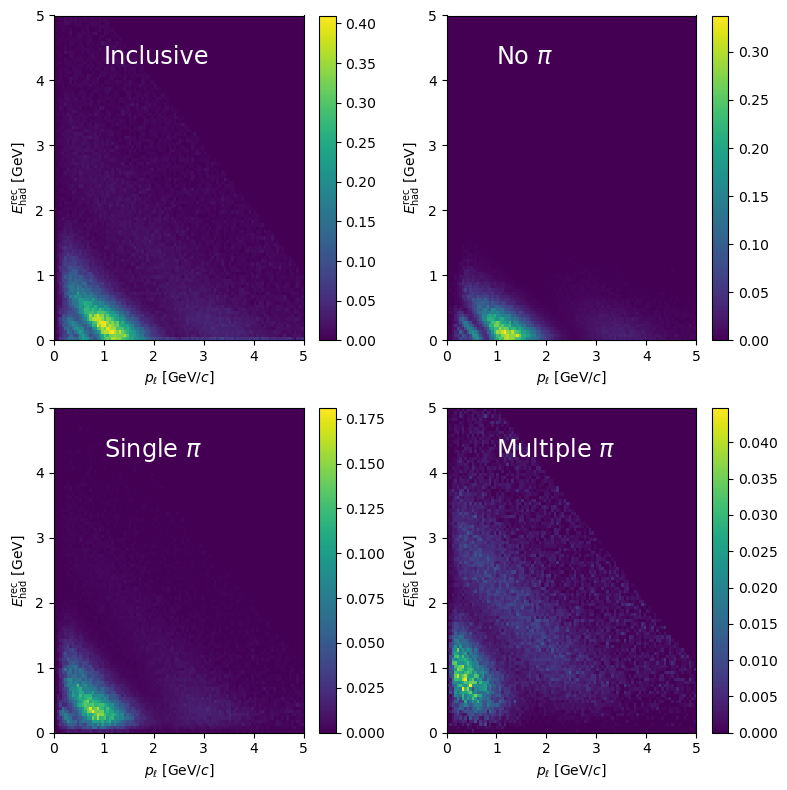

In [10]:
eventrate_per_topo(["plep", [0,5,100], r"$p_\ell$ [GeV/$c$]"], ["EHadAv_Mnv", [0,5,100], r"$E_\mathrm{had}^\mathrm{rec}$ [GeV]"], doosc=True)

The oscillations occur as diagonal bands, which is not ideal, and projecting to ENuRec, which is an important variable for plot-making, is a non-trivial operation. Instead, plot in ERec = ELep + EHad vs. plep. Here we still miss angle/transverse kinematic information, but keeping things 2D for the moment seems sensible.

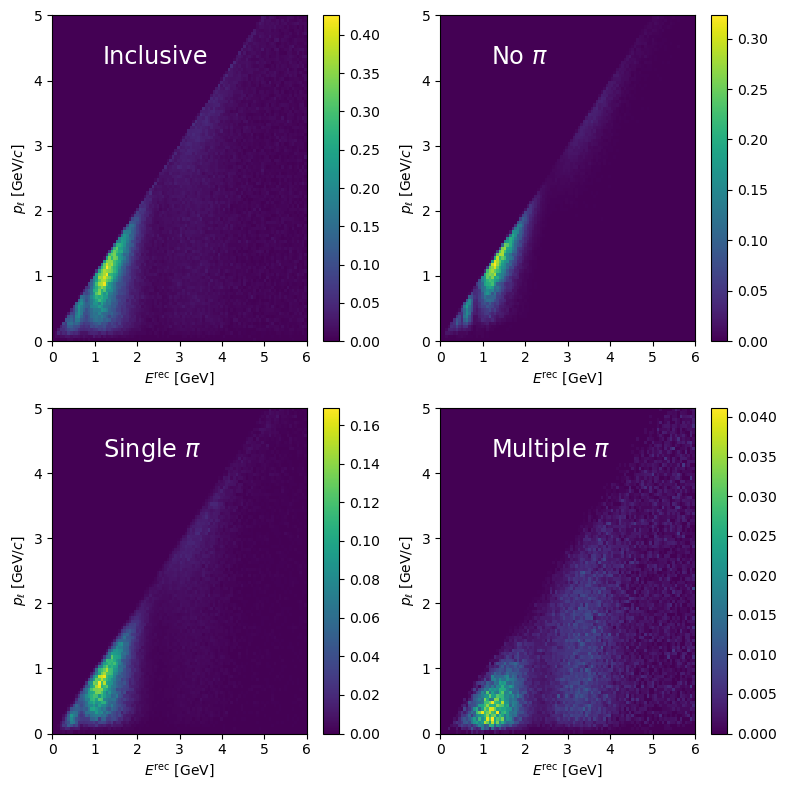

In [11]:
eventrate_per_topo(["ERec", [0,6,100], r"$E^\mathrm{rec}$ [GeV]"], ["plep", [0,5,100], r"$p_\ell$ [GeV/$c$]"], doosc=True)

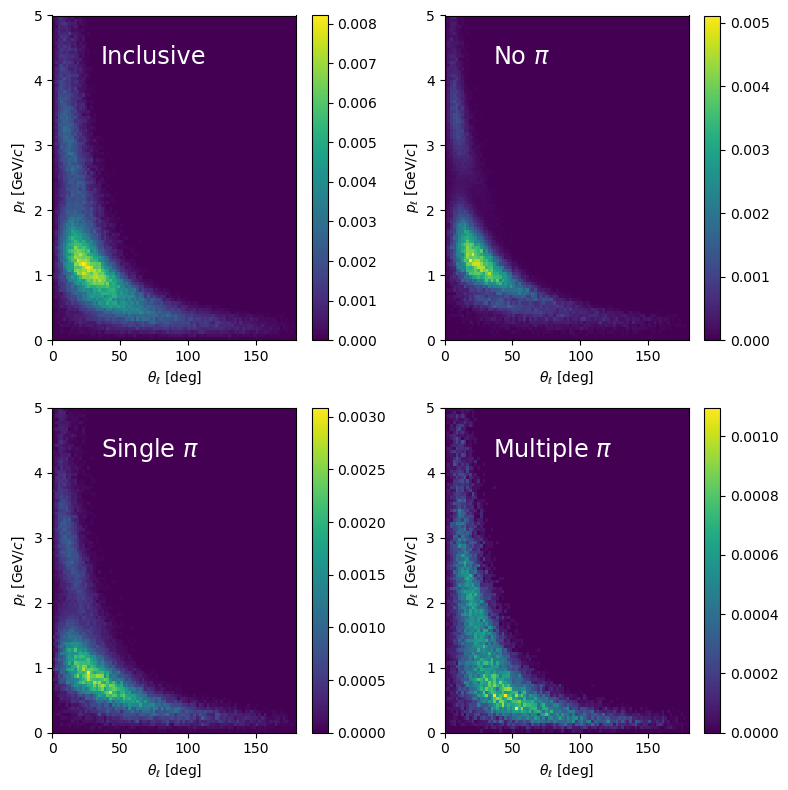

In [12]:
eventrate_per_topo(["thetalep", [0,180,90], r"$\theta_\ell$ [deg]"], ["plep", [0,5,100], r"$p_\ell$ [GeV/$c$]"], doosc=True)

# Analysis Binning

Define the analysis binning, try in ERec and plep, only want to bin in the lower half triangle (enurec = plep + ehadav). Motivation is as above, but now we want fewer bins so try and optimise it a bit.

In [13]:
class observation:
    def __init__(self):
        self.proj = []
        self.bins = []
    def add_observables(self, projections, bins):
        if isinstance(projections, list):
            self.proj.extend(projections)
        else:
            self.proj.append(projections)
        self.bins.append(bins)
    def plot(self, ef, doosc=False):
        
        projs = self.proj
        
        if len(projs) == 1:
            fig, axes = plt.subplots(1,1, figsize=(4,4))
        elif len(projs) == 2:
            fig, axes = plt.subplots(2,2, figsize=(8,8))
        else:
            raise RuntimeError("Cannot currently have a N>2 dimension analysis")

        anabins = self.anabins()

        hist = pn.HistFrame(anabins, "CC+NC Inc")
        
        fillops = [pn.HistFrame.fill_column(0), 
                   pn.HistFrame.categorize_by("topo", topo_labels)]
        if doosc:
            fillops.append(pn.HistFrame.weight_by("wosc"))
        
        hist.fill(ef, projs, fillops)
        hist = hist.finalise()
        hist = hist.scale(gnorm.fatx_per_sumweights())
        if len(projs) == 1:
            hist.mpl().hist_all(histtype="step", plot_axis=axes)
            axes.legend()
            
        elif len(projs) == 2:
            cm = hist.mpl().colormesh(column="CC+NC Inc",plot_axis=axes[0][0])
            plt.gcf().colorbar(cm, ax=axes[0][0])
            axes[0][0].text(1,4,"Inclusive",color="black", size="xx-large")
            
            cm = hist.mpl().colormesh(column="CC0Pi",plot_axis=axes[0][1])
            plt.gcf().colorbar(cm, ax=axes[0][1])
            axes[0][1].text(1,4,r"No $\pi$",color="black", size="xx-large")
            
            cm = hist.mpl().colormesh(column="CC1Pi",plot_axis=axes[1][0])
            plt.gcf().colorbar(cm, ax=axes[1][0])
            axes[1][0].text(1,4,r"Single $\pi$",color="black", size="xx-large")
            
            cm = hist.mpl().colormesh(column="CCMultiPi",plot_axis=axes[1][1])
            plt.gcf().colorbar(cm, ax=axes[1][1])
            axes[1][1].text(1,4,r"Multiple $\pi$",color="black", size="xx-large")
            
        fig.tight_layout()
        fig.show()

    def projs(self):
        return self.proj
    def anabins(self):
        return pn.Binning.product(self.bins)


In [14]:
binExts = []
ENuBinEdges_fine = [0,0.5,0.6,0.7,0.8,0.9,1,
                     1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.85,1.9,1.95,2,
                     2.05,2.1,2.15,2.2,2.25,2.3,2.35,2.4,2.45,2.5,2.55,2.6,2.65,2.7,2.75,2.8,2.9,3,
                     3.1,3.2,3.4,3.6,4,
                     4.4,4.8,5.2,5.6,6]

PLepBWMin = 0.1 #100 MeV
PLepBWMaxFraction = 0.05 # 5% of PLep

for bi in range(len(ENuBinEdges_fine)-1):
    ERecExt = pn.Binning.SingleExtent(ENuBinEdges_fine[bi], ENuBinEdges_fine[bi+1])
    PLepBL = 0
    while PLepBL <= ENuBinEdges_fine[bi+1]:
        PLepBW = max(PLepBWMin, PLepBWMaxFraction * (2.0*PLepBL + PLepBWMin)/2.0)
        PLepBU = min(PLepBL + PLepBW,ENuBinEdges_fine[bi+1])

        if PLepBU <= PLepBL:
            break

        PLepExt = pn.Binning.SingleExtent(PLepBL, PLepBU)
        binExts.append([ERecExt, PLepExt])
        PLepBL = PLepBU

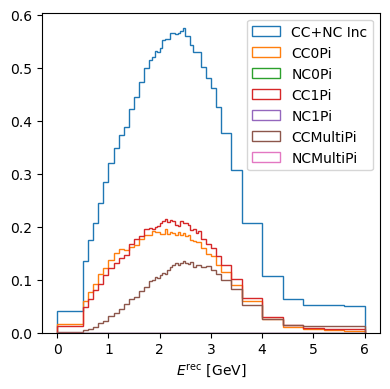

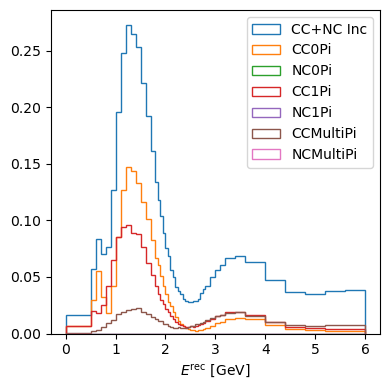

In [15]:
erec_observation = observation()
erec_observation.add_observables(["ERec"], 
                        pn.Binning.contiguous(ENuBinEdges_fine, r"$E^\mathrm{rec}$ [GeV]"))

erec_observation.plot(ef, doosc=False)
erec_observation.plot(ef, doosc=True)

1042 Analysis Bins defined


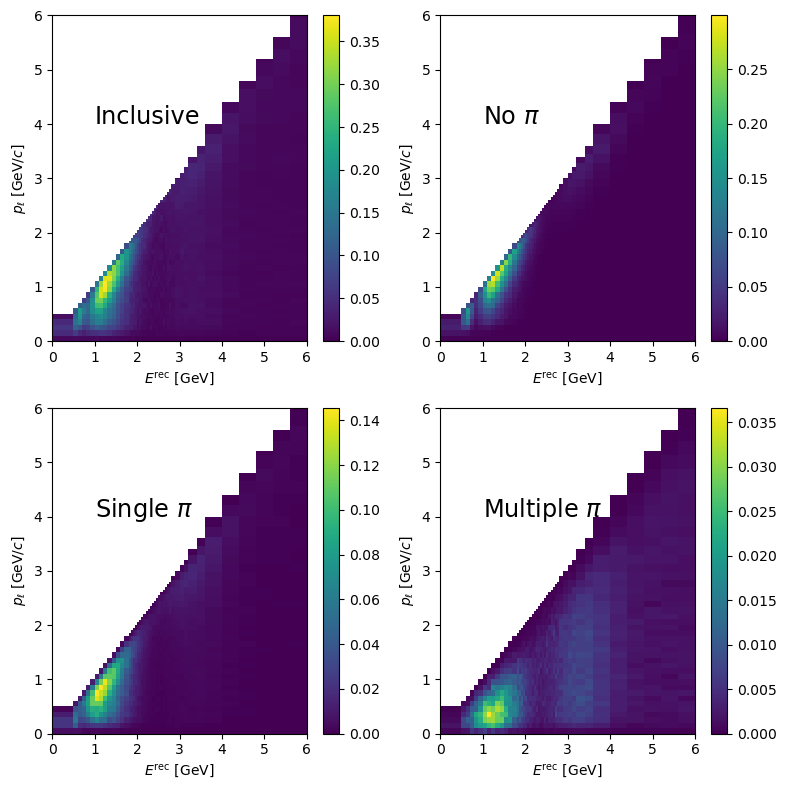

In [16]:
erec_plep_observation = observation()
erec_plep_observation.add_observables(["ERec","plep"], 
                        pn.Binning.from_extents(binExts, [r"$E^\mathrm{rec}$ [GeV]", r"$p_\ell$ [GeV/$c$]"]))

erec_plep_observation.plot(ef, doosc=True)

anabins = erec_plep_observation.anabins()
nanabins = len(anabins.bins)
print(f"{nanabins} Analysis Bins defined")

# Systematic Model

Specify 2D or 3D true kinematic space used to define 'binned' normalisation model

In [17]:
class model:
    def __init__(self):
        self.dims = []
    def add_axis(self, projection, binning):
        self.dims.append((projection, binning))
    def plot(self,ef):
        ndims = len(self.dims)

        plt.figure(figsize=(ndims*4, ndims*4))
        
        for x in range(ndims):
            for y in range(ndims):
                if x > y:
                    continue

                ax = plt.subplot(ndims, ndims, 1 + x + y*ndims)

                if x == y:
                    d = self.dims[x]
                    hist = pn.HistFrame(d[1])
                    hist.fill(ef, d[0], [pn.HistFrame.fill_column(0), pn.HistFrame.categorize_by("topo", topo_labels)])
                    hist = hist.finalise()
                    hist = hist.scale(gnorm.fatx_per_sumweights())
                    orientation = 'horizontal' if x > 0 else 'vertical'
                    hist.mpl().hist_all(histtype="step", plot_axis=ax, orientation=orientation)
                    if x > 0:
                        ax.set_ylabel(d[1].axis_labels[0])
                        ax.set_xlabel("")
                    else:
                        ax.legend()
                else:
                    dx = self.dims[x]
                    dy = self.dims[y]
                    hist = pn.HistFrame(pn.Binning.product([dx[1],dy[1]]))
                    hist.fill(ef, [dx[0], dy[0]])
                    hist = hist.finalise()
                    hist = hist.scale(gnorm.fatx_per_sumweights())
                    cm = hist.mpl().colormesh(plot_axis=ax)
                    plt.gcf().colorbar(cm, ax=ax)

        plt.tight_layout()
        plt.show()

    def plot_errors(self, param_errors):
        ndims = len(self.dims)

        hist = pn.BinnedValues(self.systbins())
        bcs = np.copy(hist.values)
        bcs[:, 0] = param_errors
        hist.values = bcs
        
        if ndims == 1:
            hist.mpl().hist(histtype="step")
            plt.ylabel("fractional error")
            plt.show()
        elif ndims == 2:
            cm = hist.mpl().colormesh()
            plt.gcf().colorbar(cm, ax=plt.gca())
            plt.show()
        else:
            raise RuntimeError("Cannot plot variances for ndims > 2") 

    def systbins(self):
        return pn.Binning.product([d[1] for d in self.dims])
    def projs(self):
        return [d[0] for d in self.dims]


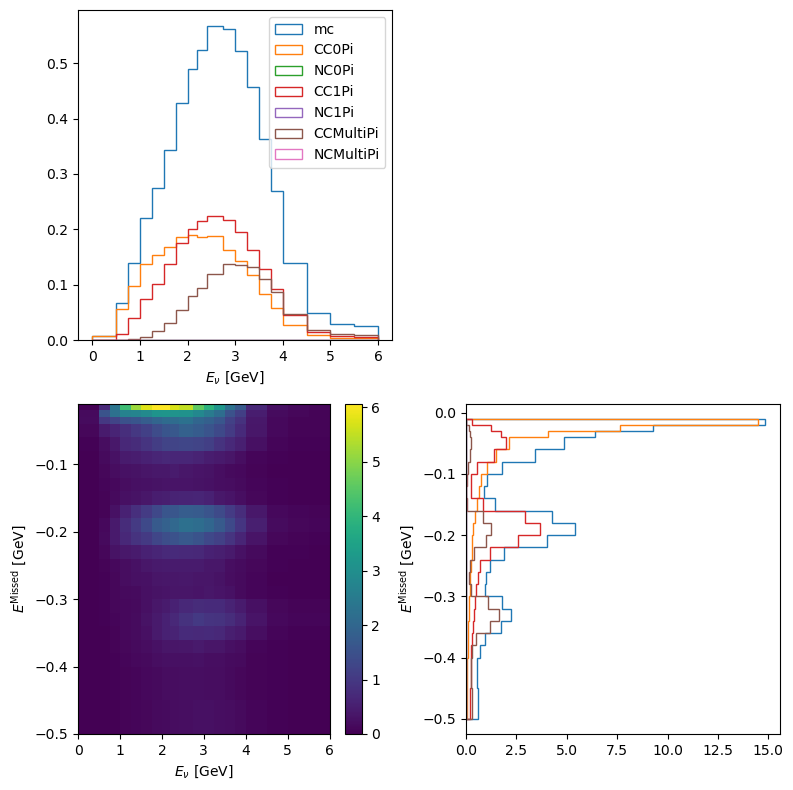

In [18]:
test2Dmodel = model()
test2Dmodel.add_axis("enu", 
                     pn.Binning.contiguous(
                         [0,0.5,0.75,1,1.25,1.5,1.75,2,2.2,2.4,2.75,3,3.25,3.5,3.75,4,4.5,5,5.5,6], 
                         r"$E_\nu$ [GeV]"))
test2Dmodel.add_axis("ERecMissed", 
                     pn.Binning.contiguous(
                         list(reversed([-0.01,-0.02,-0.03,-0.04,-0.06,-0.08,-0.1,-0.12,-0.14,-0.16,-0.18,
                                        -0.2,-0.22,-0.24,-0.26,-0.28,-0.3,-0.32,-0.34,-0.36,-0.38,-0.4,-0.45,-0.5]))
                         ,r"$E^\mathrm{Missed}$ [GeV]"))

test2Dmodel.plot(ef)

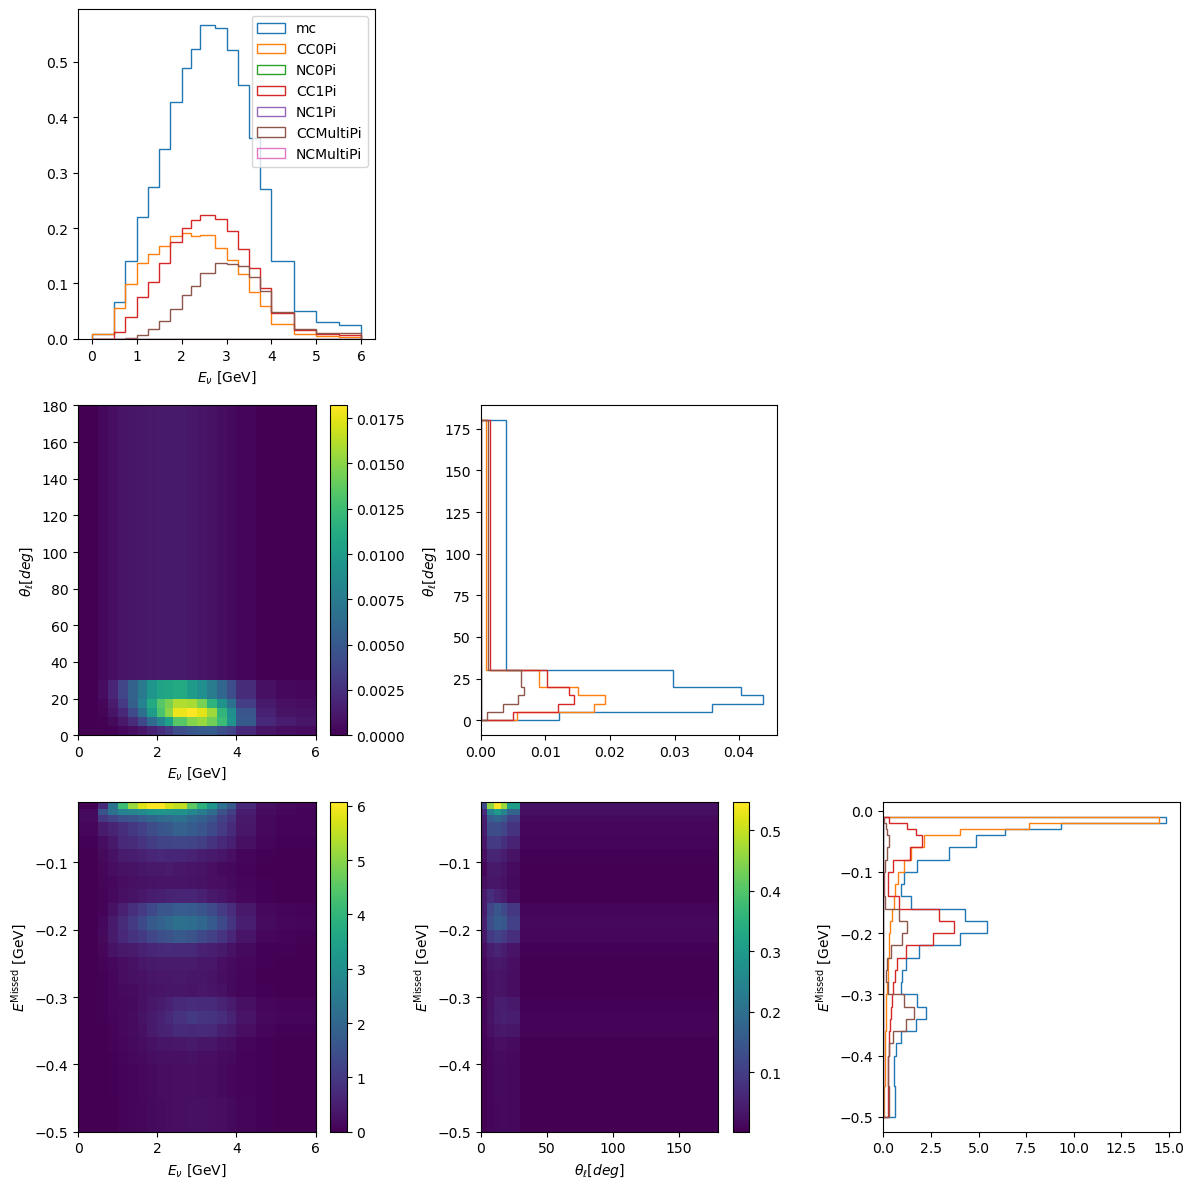

In [19]:
test3Dmodel = model()
test3Dmodel.add_axis("enu", 
                     pn.Binning.contiguous(
                         [0,0.5,0.75,1,1.25,1.5,1.75,2,2.2,2.4,2.75,3,3.25,3.5,3.75,4,4.5,5,5.5,6], 
                         r"$E_\nu$ [GeV]"))
test3Dmodel.add_axis("thetalep", 
                     pn.Binning.contiguous([0,5,10,15,20,30,180],
                                           r"$\theta_\ell [deg]$"))
test3Dmodel.add_axis("ERecMissed", 
                     pn.Binning.contiguous(
                         list(reversed([-0.01,-0.02,-0.03,-0.04,-0.06,-0.08,-0.1,-0.12,-0.14,-0.16,-0.18,
                                        -0.2,-0.22,-0.24,-0.26,-0.28,-0.3,-0.32,-0.34,-0.36,-0.38,-0.4,-0.45,-0.5]))
                         ,r"$E^\mathrm{Missed}$ [GeV]"))

test3Dmodel.plot(ef)

In [20]:
mymodel = test2Dmodel

In [21]:
systbins = mymodel.systbins()
nsyst = len(systbins.bins)
print(f"Have {nsyst} normalisation bins in the model")

Have 437 normalisation bins in the model


In [22]:
proj_names = mymodel.projs()
nprojs = len(proj_names)
df['systbin'] = df.apply(lambda x: systbins.find_bin([x[proj_names[i]] for i in range(nprojs)]), axis=1)
df

,event.number,weight.cv,fatx_per_sumw.pb_per_target.estimate,fatx_per_sumw.pb_per_nucleon.estimate,process.id,enu,topo,q0,q3,W,plep,thetalep,EHadAv_Mnv,wosc,ERec,YRec,ERecMissed,ERecBias,systbin
5,7,1.0,6.948408e-02,5.790340e-03,600,4.428937,2,3.231451,3.677136,2.176015,1.192815,44.647601,2.523430,0.350898,3.716245,0.679027,-0.712692,-0.160917,4294967295
7,9,1.0,5.558726e-02,4.632272e-03,500,2.795027,2,1.441489,1.963942,1.304047,1.349408,40.029092,1.393553,0.016212,2.742961,0.508047,-0.052067,-0.018628,371
8,12,1.0,4.275943e-02,3.563286e-03,300,2.598061,0,0.546930,0.905409,2.273883,2.048408,17.942483,0.438915,0.012332,2.487323,0.176461,-0.110738,-0.042623,313
9,13,1.0,3.970519e-02,3.308766e-03,400,3.146805,0,0.706227,0.898746,1.374674,2.438290,11.456494,0.653080,0.067379,3.091369,0.211259,-0.055436,-0.017617,372
10,14,1.0,3.705817e-02,3.088181e-03,600,5.904933,4,4.393155,4.694525,2.435399,1.508082,31.999795,3.799000,0.581567,5.307082,0.715836,-0.597851,-0.101246,4294967295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745225,999973,1.0,5.558871e-07,4.632392e-08,400,1.062748,2,0.561350,0.942154,1.216885,0.490139,62.439756,0.233056,0.491653,0.723195,0.322259,-0.339553,-0.319504,98
745230,999978,1.0,5.558843e-07,4.632369e-08,500,3.218134,-1,1.550063,1.794878,1.559174,1.664722,22.400504,1.491231,0.081680,3.155952,0.472514,-0.062182,-0.019322,353
745233,999984,1.0,5.558810e-07,4.632341e-08,200,3.414840,2,0.950818,1.600283,0.938272,2.461756,25.616110,0.671868,0.124518,3.133624,0.214406,-0.281217,-0.082351,145
745235,999986,1.0,5.558798e-07,4.632332e-08,600,2.822932,2,2.292094,2.786991,1.638997,0.520217,80.747262,1.761934,0.018588,2.282151,0.772050,-0.540781,-0.191567,4294967295


We can now look at the number of events controlled by each systematic. Ideally this would be fairly flat...

In [23]:
ef = pa.Table.from_pandas(df)

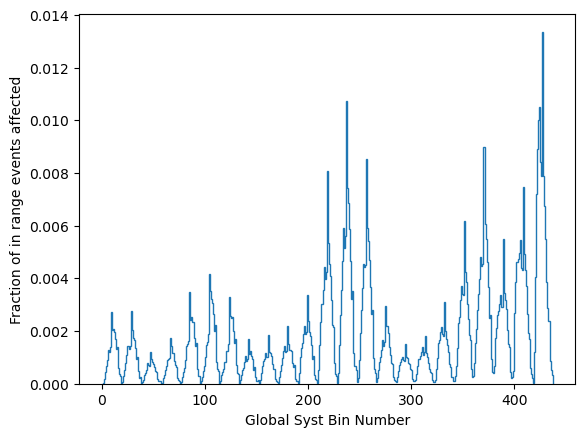

In [24]:
systbincount = pn.HistFrame(pn.Binning.lin_space(0,len(systbins.bins),len(systbins.bins),"Global Syst Bin Number"))

systbincount.fill(ef, "systbin")
systbincount = systbincount.scale(1.0/float(ef.num_rows))
systbincount.mpl().hist(histtype="step")
plt.ylabel("Fraction of in range events affected")
plt.show()

In [25]:
import numpy as np

thresholds = [0.00001,0.0001,0.0005, 0.001, 0.0015, 0.002]

bc = systbincount.sumweights[:, 0]

for t in thresholds:
    nbins_above_t = np.count_nonzero(bc > t)
    print(f"{nbins_above_t}/{len(bc)} syst params affect more than {t*100}% of the events")

427/437 syst params affect more than 0.001% of the events
407/437 syst params affect more than 0.01% of the events
327/437 syst params affect more than 0.05% of the events
236/437 syst params affect more than 0.1% of the events
174/437 syst params affect more than 0.15% of the events
130/437 syst params affect more than 0.2% of the events


We can build a reduced parameterisation by only including parameters that affect 0.01% of the events or more.

In [26]:
reduced_systbins = []
for i in range(bc.shape[0]):
    if bc[i] > 0.0001:
        reduced_systbins.append(systbins.bins[i])
reduced_systmodel = pn.Binning.from_extents(reduced_systbins)

In [27]:
print(len(reduced_systmodel.bins))

407


In [94]:
proj_names = mymodel.projs()
nprojs = len(proj_names)
df['systbin_red'] = df.apply(lambda x: reduced_systmodel.find_bin([x[proj_names[i]] for i in range(nprojs)]), axis=1)
df

,event.number,weight.cv,fatx_per_sumw.pb_per_target.estimate,fatx_per_sumw.pb_per_nucleon.estimate,process.id,enu,topo,q0,q3,W,plep,thetalep,EHadAv_Mnv,wosc,ERec,YRec,ERecMissed,ERecBias,systbin,systbin_red
5,7,1.0,6.948408e-02,5.790340e-03,600,4.428937,2,3.231451,3.677136,2.176015,1.192815,44.647601,2.523430,0.350898,3.716245,0.679027,-0.712692,-0.160917,4294967295,4294967295
7,9,1.0,5.558726e-02,4.632272e-03,500,2.795027,2,1.441489,1.963942,1.304047,1.349408,40.029092,1.393553,0.016212,2.742961,0.508047,-0.052067,-0.018628,371,342
8,12,1.0,4.275943e-02,3.563286e-03,300,2.598061,0,0.546930,0.905409,2.273883,2.048408,17.942483,0.438915,0.012332,2.487323,0.176461,-0.110738,-0.042623,313,286
9,13,1.0,3.970519e-02,3.308766e-03,400,3.146805,0,0.706227,0.898746,1.374674,2.438290,11.456494,0.653080,0.067379,3.091369,0.211259,-0.055436,-0.017617,372,343
10,14,1.0,3.705817e-02,3.088181e-03,600,5.904933,4,4.393155,4.694525,2.435399,1.508082,31.999795,3.799000,0.581567,5.307082,0.715836,-0.597851,-0.101246,4294967295,4294967295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745225,999973,1.0,5.558871e-07,4.632392e-08,400,1.062748,2,0.561350,0.942154,1.216885,0.490139,62.439756,0.233056,0.491653,0.723195,0.322259,-0.339553,-0.319504,98,84
745230,999978,1.0,5.558843e-07,4.632369e-08,500,3.218134,-1,1.550063,1.794878,1.559174,1.664722,22.400504,1.491231,0.081680,3.155952,0.472514,-0.062182,-0.019322,353,324
745233,999984,1.0,5.558810e-07,4.632341e-08,200,3.414840,2,0.950818,1.600283,0.938272,2.461756,25.616110,0.671868,0.124518,3.133624,0.214406,-0.281217,-0.082351,145,129
745235,999986,1.0,5.558798e-07,4.632332e-08,600,2.822932,2,2.292094,2.786991,1.638997,0.520217,80.747262,1.761934,0.018588,2.282151,0.772050,-0.540781,-0.191567,4294967295,4294967295


In [98]:
ef = pa.Table.from_pandas(df)
test2Dredmodel = model()
test2Dredmodel.add_axis("systbin_red", pn.Binning.lin_space(0,407,407))

# Building an Analysis

We need a few more moving parts for this analysis. We need a likelihood function, we'll use a Poisson likelihood, but express it as a negative log likelihood for ease of numerical handling. We also want a way to calculate an 'online' estimate of the mean and variance.

In [29]:
from math import inf

def nllh(data, mc):
    if np.count_nonzero(mc < 0):
        return inf
    mcad = np.logical_and(mc > 0,data > 0)
    mco = np.logical_and(mc > 0,data == 0)

    mc_mcad = mc[mcad]
    data_mcad = data[mcad]

    nllh = np.sum(mc_mcad - data_mcad + data_mcad * np.log(np.divide(data_mcad ,mc_mcad)))
    nllh = nllh + np.sum(mc[mco])

    return nllh

class online_stats:
    def __init__(self, nanabins):
        self.agg = (0, np.zeros(nanabins), np.zeros(nanabins))
    ## From https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm

    # For a new value new_value, compute the new count, new mean, the new M2.
    # mean accumulates the mean of the entire dataset
    # M2 aggregates the squared distance from the mean
    # count aggregates the number of samples seen so far
    def update(self, new_value):
        (count, mean, M2) = self.agg
        count += 1
        delta = new_value - mean
        mean += delta / count
        delta2 = new_value - mean
        M2 += delta * delta2
        self.agg = (count, mean, M2)
    
    # Retrieve the mean, variance and sample variance from an aggregate
    def finalize(self):
        (count, mean, M2) = self.agg
        if count < 2:
            return float("nan")
        else:
            (mean, variance, sample_variance) = (mean, M2 / count, M2 / (count - 1))
            return (mean, variance, sample_variance)

With these we can build an analysis class, that houses all of the moving parts

In [30]:
class Analysis:
    def __init__(self, efa, observables, systematic_model, evrate=10000):
        self.ef = efa

        self.obs = observables

        self.anabins = self.obs.anabins()
        self.nanabins = len(self.anabins.bins)
        self.anabinIds = pn.Binning.find_bins(self.anabins, self.ef, self.obs.projs())
        
        self.systs = systematic_model

        self.systbins = self.systs.systbins()
        self.nsyst = len(self.systbins.bins)
        
        self.systbinIds = pn.Binning.find_bins(self.systbins, self.ef, self.systs.projs())
        self.systbin_affected = np.logical_and(self.systbinIds >= 0,self.systbinIds < self.nsyst)
        self.nevents = len(self.systbinIds)

        self.scalef = 1
        self.scalef = float(evrate)/np.sum(self.predict().sumweights[:,0])
        
        self.datah = self.predict()
        self.data = self.datah.sumweights[:,0]

    def systbins_event_rate(self):
        systbincount = pn.HistFrame(pn.Binning.lin_space(0,len(self.systbins.bins),len(self.systbins.bins),"Global Syst Bin Number"))
        systbincount.fill(self.ef, [], [pn.HistFrame.fill_column(0), pn.HistFrame.prebinned_array(self.systbinIds)])
        return systbincount

    def plot_systbins_event_rate(self):
        systbincount = self.systbins_event_rate()
        systbincount.mpl().hist(histtype="step")
        plt.ylabel("Number events affected")
        plt.show()

    def calc_event_weights(self, paramvs):
        ws = np.ones(self.nevents)
        ws[self.systbin_affected] = paramvs[self.systbinIds[self.systbin_affected]]
        return ws
    
    def predict(self, paramvs=None):
        Ana2dHist = pn.HistFrame(self.anabins)
    
        fillops = [pn.HistFrame.fill_column(0), pn.HistFrame.prebinned_array(self.anabinIds)]
    
        if paramvs is not None:
            fillops.append(pn.HistFrame.weight_by_array(self.calc_event_weights(paramvs)))
        
        Ana2dHist.fill(self.ef, [], fillops)
        
        return Ana2dHist.scale(self.scalef)

    def predict_other(self, anabins, projs=[], binIds=None, paramvs=None):
        Ana2dHist = pn.HistFrame(anabins)
    
        fillops = [pn.HistFrame.fill_column(0)]

        if binIds is not None:
            fillops.append(pn.HistFrame.prebinned_array(binIds))
    
        if paramvs is not None:
            fillops.append(pn.HistFrame.weight_by_array(self.calc_event_weights(paramvs)))
        
        Ana2dHist.fill(self.ef, projs, fillops)
    
        return Ana2dHist.scale(self.scalef)

    def nllh(self,paramvs):
        return nllh(self.data, self.predict(paramvs).sumweights[:, 0])
    
    def throws(self, toy_params, anabins=None, projs=None):

        if anabins is None:
            anabins = self.anabins
            projs = self.obs.projs()

        os = online_stats(len(anabins.bins))

        anabinIds = pn.Binning.find_bins(anabins, self.ef, projs)
        
        for ti in range(toy_params.shape[0]):
            os.update(self.predict_other(anabins, binIds=anabinIds, paramvs=toy_params[ti,:]).sumweights[:,0])
        fin = os.finalize()

        cv = self.predict_other(anabins=anabins, binIds=anabinIds)
        cv.sumweights = fin[0]
        cv.variances = fin[2]

        return cv

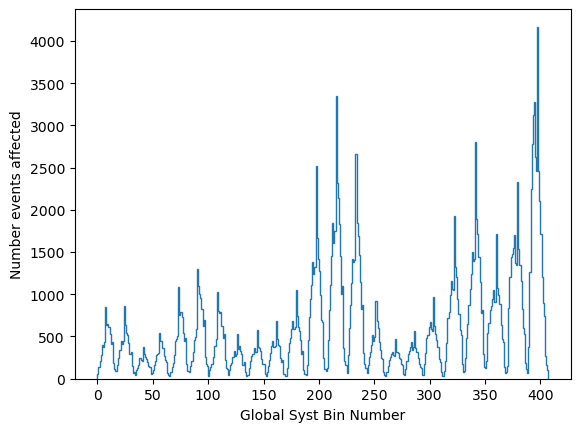

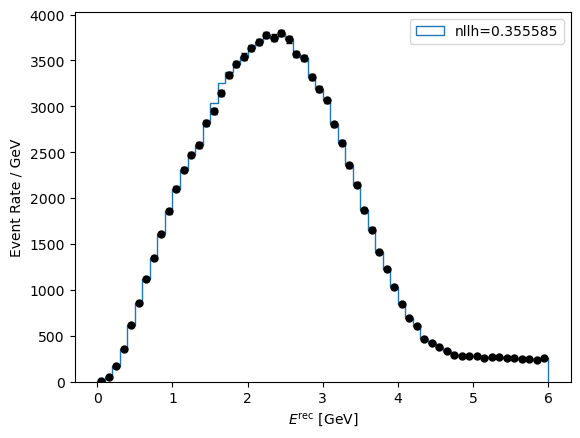

In [162]:
obs = observation()
obs.add_observables("ERec", pn.Binning.lin_space(0,6,60,r"$E^\mathrm{rec}$ [GeV]"))

myana = Analysis(ef, obs, test2Dredmodel, 10000)
myana.plot_systbins_event_rate()
plt.show()
myana.datah.finalise().mpl().data_hist()
paramvs = np.ones(myana.nsyst)
paramvs[5] = 3
myana.predict(paramvs=paramvs).finalise().mpl().hist(histtype="step", label=f"nllh={myana.nllh(paramvs):g}")
plt.ylabel("Event Rate / GeV")
plt.legend()
plt.show()

Build 1D likelihood scans of the parameters that affect the most number of events (not neccessarily the parameters that have the largest effect on the likelihood).

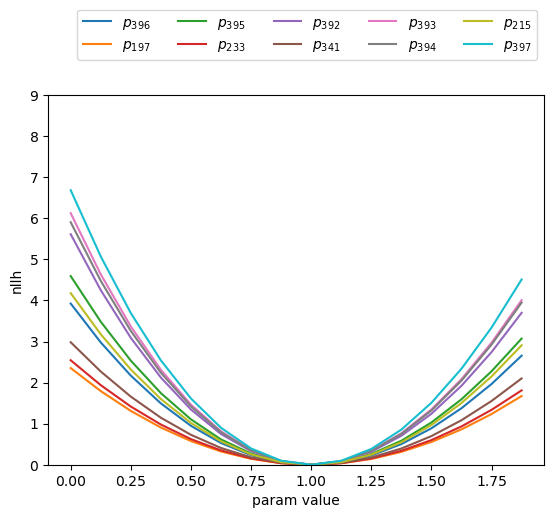

In [163]:
param_event_counts = myana.systbins_event_rate().sumweights[:,0]

for p_i in np.nditer(np.argsort(param_event_counts)[-10:]):
    x = []
    y = []
    for i in np.arange(-2,2,0.25):
        paramvs = np.ones(myana.nsyst)
        paramvs[p_i] = 1 + i*0.5
        x.append(paramvs[p_i])
        y.append(myana.nllh(paramvs))

    plt.plot(x,y, label=f"$p_{{{p_i}}}$")
plt.legend(ncol=5,bbox_to_anchor=(0., 1.05, 1., 0.2))
plt.xlabel("param value")
plt.ylabel("nllh")
plt.ylim(0,9)
plt.show()

In [294]:
from scipy import optimize as so

def get_wilks_1sig(xv, yv):
    if yv[-1] < 0.5:
        return inf
    return so.brentq(lambda x: np.interp(x, xv, yv) - 0.5, xv[0], xv[-1])

lhood_scan_uncerts = []
for p_i in range(myana.nsyst):
    x = []
    y = []
    for i in np.arange(0,3,0.2):
        paramvs = np.ones(myana.nsyst)
        paramvs[p_i] = 1 + i
        x.append(paramvs[p_i])
        y.append(myana.nllh(paramvs))
    lhood_scan_uncerts.append(get_wilks_1sig(x,y))

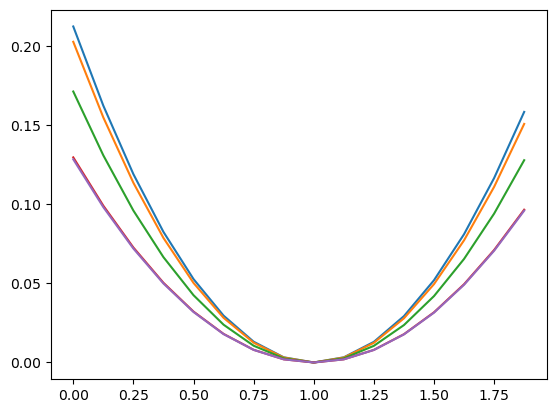

In [295]:
for p_i in [9, 10, 11, 12, 13]:
    x = []
    y = []
    for i in np.arange(-2,2,0.25):
        paramvs = np.ones(myana.nsyst)
        paramvs[p_i] = 1 + i*0.5
        x.append(paramvs[p_i])
        y.append(myana.nllh(paramvs))

    plt.plot(x,y, label=f"$p_{{{p_i}}}$")

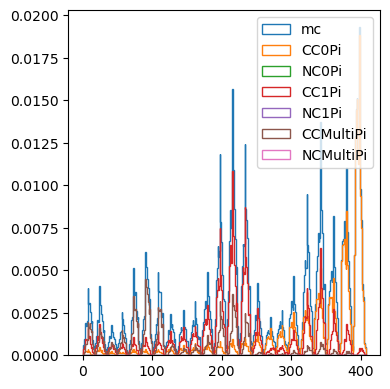

/usr/local/lib64/python3.9/site-packages/numpy/lib/function_base.py:1423: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


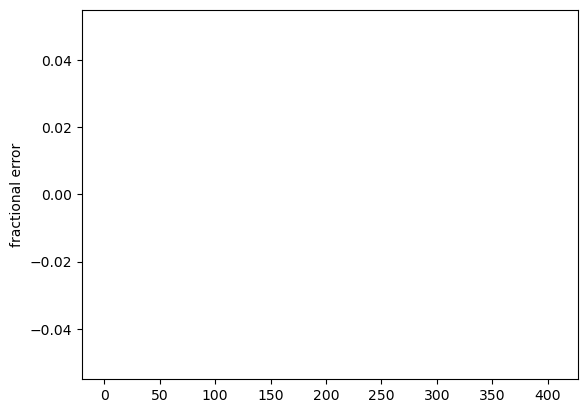

In [296]:
myana.systs.plot(ef)
myana.systs.plot_errors(lhood_scan_uncerts)

In [286]:
from math import exp
from os import path, system

class Chain:
    def __init__(self, *, nparams=None, filename_stub="chain_"):

        self.filename_stub = filename_stub

        if nparams is None: # read input files
            files = self._files()
            if len(files) == 0:
                raise RuntimeError(f"Chain initialized from input filename stub: {filename_stub}, but no matching files were found.")
            self.nsteps = 0
            
            for fn in files:
                pf = pd.read_parquet(files[0])
                self.nparams = pf.shape[1] - 2
                self.nsteps = self.nsteps + pf.shape[0]
            
            self.step_0 = self.nsteps
            self.file_index = len(files)
        else:
            self.nparams = nparams
            self.nsteps = 0
            self.step_0 = 0
            self.file_index = 0
            if path.isfile(f"{self.filename_stub}0.pq"):
                raise RuntimeError(f"not starting new chain when file:{self.filename_stub}0.pq exists. Please move it or supply another filename_stub")

        self.capacity_increment = 10000
        self.resident_capacity = 0        

        self.state = np.zeros((self.resident_capacity, self.nparams+2), order="F", dtype=np.float32)

    def __str__(self):
        return \
f"""
chain:
  nparams: {self.nparams}
  nsteps: {self.nsteps}
  nsteps on disk: {self.step_0}
  resident_capacity: {self.resident_capacity}
  nfiles: {self.file_index}
"""
    
    def _offload_batch(self):
        colnames = ["lhood", "transition_probability"]
        colnames.extend([f"p{x}_value" for x in range(self.nparams)])
        pd.DataFrame(self.state, columns=colnames).to_parquet(f"{self.filename_stub}{self.file_index}.pq")
        print(f"Wrote chain step batch to {self.filename_stub}{self.file_index}.pq")
        self.file_index = self.file_index + 1

        self.resident_capacity = 0
        self.state = np.zeros((self.resident_capacity, self.nparams+2), order="F", dtype=np.float32)
        self.step_0 = self.nsteps
    
    def _expand(self):
        if self.state.nbytes >= (1024 * 1024 * 1024):
            self._offload_batch()
        
        self.resident_capacity = self.resident_capacity + self.capacity_increment
        hold = np.copy(self.state)
        self.state = np.zeros((self.resident_capacity, self.nparams+2), order="F", dtype=np.float32)
        self.state[0:self.nsteps - self.step_0, :] = hold

    def _files(self):
        files = []

        file_index = 0
        fname = f"{self.filename_stub}{file_index}.pq"
        while path.isfile(fname):
            files.append(fname)
            file_index = file_index + 1
            fname = f"{self.filename_stub}{file_index}.pq"
        return files
    
    def col(self, coli, stop=None, start=0):
        if stop is None:
            stop = self.nsteps
        else:
            stop = min(stop, self.nsteps)
        
        if self.file_index == 0:
            return self.state[start:stop, coli]
        
        if coli == 0:
            colname = "lhood"
        elif coli == 1:
            colname = "transition_probability"
        else:
            colname = f"p{coli-2}_value"

        df = None
        for f in self._files():
            tdf = pd.read_parquet(f, columns=[colname])
            df = tdf if df is None else pd.concat([df, tdf])

            if df.shape[0] >= stop:
                break

        return np.concatenate([df.to_numpy()[:, 0],self.state[:, coli]])[start:stop]

    def cov(self, stop=None, start=0):
        if stop is None:
            stop = self.nsteps
        else:
            stop = min(stop, self.nsteps)

        if self.file_index == 0:
            print(f"Calculating Covariance from in-memory state between entry {start} to {stop} = {stop-start}.")
            return np.cov(self.state[start:stop, 2:], rowvar=False)
        else:
            cov = np.zeros((self.nparams,self.nparams), dtype=np.float32)
            nlines_read = 0
            entries_included = 0
            print(f"Calculating Covariance from entry {start} to {stop} = {stop-start}.")
            for f in self._files():
                fst = pd.read_parquet(f).to_numpy()[:,2:]
                print(f"  - read file: {f} with {fst.shape[0]} entries.")

                if (fst.shape[0] + nlines_read) < start:
                    nlines_read = nlines_read + fst.shape[0]
                    continue

                fstart = 0
                fstop = min(stop - nlines_read, fst.shape[0])
                print(f"    < {fstop} - {fstart} = {fstop - fstart} entries.")
                fstv = fst[fstart:fstop, :]
                print(" sub cov from file: ", np.cov(fstv, rowvar=False))
                cov = cov + np.cov(fstv, rowvar=False)*(fstv.shape[0]-1)
                
                entries_included = entries_included + (fstop - fstart)
                nlines_read = nlines_read + fst.shape[0]
                print(f"    ! Read {nlines_read} lines and processed {entries_included} entries.")

                if (start + entries_included) >= stop:
                    return cov / float(entries_included - 1)

            fstart = 0
            fstop = min(stop - nlines_read, self.state.shape[0])
            print(f"  + Including {fstop - fstart} entries from in-memory state.")
            
            cov = cov + np.cov(self.state[fstart:fstop, 2:], rowvar=False)
            entries_included = entries_included + (fstop - fstart)

            return cov / float(entries_included - 1)
    
    def step(self, pvals, lhood, step_prob):
        if self.nsteps == self.resident_capacity:
            self._expand()
            
        self.state[self.nsteps - self.step_0, 0] = lhood
        self.state[self.nsteps - self.step_0, 1] = step_prob
        self.state[self.nsteps - self.step_0, 2:] = pvals
        self.nsteps += 1

    def last_step(self):
        if (self.nsteps - self.step_0) > 0:
            return self.state[-1, 2:]
        elif self.file_index > 0:
            return pd.read_parquet(self._files()[-1]).to_numpy()[-1, 2:]
        else:
            raise RuntimeError("Chain.last_step called on empty chain")

    def write(self, *, fname):
        df = None
        for f in self._files():
            tdf = pd.read_parquet(f)
            print(f" + read {tdf.shape} df from {f}")
            df = tdf if df is None else pd.concat([df, tdf])

        if(self.nsteps - self.step_0):
            colnames = ["lhood", "transition_probability"]
            colnames.extend([f"p{x}_value" for x in range(self.nparams)])
            df = pd.concat([df, pd.DataFrame(self.state, columns=colnames)])
        
        return df.to_parquet(fname)
        
class ChainDiagnostics:
    def __init__(self, chain, burnin=None):
        self.chain = chain
        self.burnin = burnin

    def _burnin(self, burnin):
        if burnin is not None:
            return burnin
        if self.burnin is not None:
            return self.burnin
        return 0

    def _trace(self, coli, *, start=0, stop=None):
        if stop is None:
            stop = self.chain.nsteps
        return self.chain.col(coli, start=start, stop=stop)

    def _acf(self, coli, *, lag_max, lag_stride, burnin=None):
        burnin = self._burnin(burnin)
        
        stop = min(self.chain.nsteps - burnin, lag_max)
        c = self._trace(coli, start=burnin)
        return np.array([np.corrcoef(c[:-i],c[i:])[0,1] for i in range(1, stop, lag_stride)])

    def trace_lhood(self, nsteps, *, burnin=None):
        burnin = self._burnin(burnin)
        
        return self._trace(0, start=burnin, stop=nsteps+burnin)

    def trace_param(self, p_i, nsteps, *, burnin=None):
        burnin = self._burnin(burnin)
        
        return self._trace(2 + p_i, start=burnin, stop=nsteps+burnin)
    
    def acf_llh(self, *, lag_max=10000, lag_stride=100, burnin=None):
        burnin = self._burnin(burnin)
        
        return self._acf(0, burnin=burnin, lag_max=lag_max, lag_stride=lag_stride)

    def acf_param(self, p_i, *, lag_max=10000, lag_stride=100, burnin=None):
        burnin = self._burnin(burnin)
        
        return self._acf(2 + p_i, burnin=burnin, lag_max=lag_max, lag_stride=lag_stride)

    def _plot_trace(self, trace, *, start, stop, stride, plot_axis, label=""):
        if plot_axis is None:
            plot_axis = plt.gca()
        plot_axis.plot(np.arange(start, stop, stride), trace[np.arange(0, stop - start, stride)], label=label)

    def plot_param_trace(self, p_i, *, nsteps=10000, stride=10, burnin=None, plot_axis=None):
        burnin = self._burnin(burnin)
        
        self._plot_trace(self.trace_param(p_i, nsteps=nsteps, burnin=burnin), 
                         start=burnin, stop=(nsteps + burnin), stride=stride, 
                         plot_axis=plot_axis, label=f"param {p_i}")
    
    def plot_tprob_trace(self, *, nsteps=None, navg=100, burnin=None, plot_axis=None):
        burnin = self._burnin(burnin)
        
        if plot_axis is None:
            plot_axis = plt.gca()

        stop = None
        if nsteps is not None:
            stop = nsteps + burnin
        
        tr = self._trace(1, start=burnin, stop=stop)
                
        x = [x + navg/2.0 for x in range(burnin, burnin+tr.shape[0], navg)]
        y = [np.average(tr[i:i+navg]) for i in range(0, tr.shape[0], navg)]
        
        plot_axis.set_ylabel("Avg. Acceptance prob")
        plot_axis.set_xlabel("Step")
        plot_axis.plot(x,y)

    def plot_llh_trace(self, *, nsteps=10000, stride=10, burnin=None, plot_axis=None):
        burnin = self._burnin(burnin)
        
        self._plot_trace(self.trace_lhood(nsteps=nsteps, burnin=burnin), 
                         start=burnin, stop=(nsteps + burnin), stride=stride, 
                         plot_axis=plot_axis)

    def _plot_acf(self, trace, *, lag_max, lag_stride, plot_axis, label=""):
        if plot_axis is None:
            plot_axis = plt.gca()
        plot_axis.plot(np.arange(1, lag_max, lag_stride), trace, label=label)
        
    def plot_param_acf(self, p_i, *, lag_max=10000, lag_stride=100, burnin=None, plot_axis=None):
        burnin = self._burnin(burnin)
        
        self._plot_acf(self.acf_param(p_i, burnin=burnin, lag_max=lag_max, lag_stride=lag_stride), 
                       lag_max=lag_max, lag_stride=lag_stride, plot_axis=plot_axis, label=f"param {p_i}")

    def plot_llh_acf(self, *, lag_max=10000, lag_stride=100, burnin=None, plot_axis=None):
        burnin = self._burnin(burnin)
        
        self._plot_acf(self.acf_llh(burnin=burnin, lag_max=lag_max, lag_stride=lag_stride), 
                       lag_max=lag_max, lag_stride=lag_stride, plot_axis=plot_axis)

    def plot_param(self, p_i, *, bins=100, burnin=None, plot_axis=None):
        burnin = self._burnin(burnin)
        
        pv = self._trace(coli = 2 + p_i, start=burnin)
        if plot_axis is None:
            plot_axis = plt.gca()
        plot_axis.hist(pv, bins=bins, histtype="step")

    def plot_param2D(self, p_i, p_j, *, bins=100, burnin=None, plot_axis=None):
        burnin = self._burnin(burnin)
        
        piv = self._trace(coli = 2 + p_i, start=burnin)
        pjv = self._trace(coli = 2 + p_j, start=burnin)
        if plot_axis is None:
            plot_axis = plt.gca()
        plot_axis.hist2d(piv, pjv, bins=bins)

    def plot_covmat(self, *, burnin=None, plot_axis=None):
        burnin = self._burnin(burnin)
        
        cov = self.chain.cov(start=burnin)
        nparams = cov.shape[0]
        cvmx = pn.HistFrame(pn.Binning.lin_spaceND([[0,nparams,nparams],[0,nparams,nparams]]))
        for i in range(nparams):
            for j in range(nparams):
                cvmx.fill([i,j],cov[i,j])
        return cvmx.mpl().colormesh(plot_axis=plot_axis)
        

In [172]:
from math import isfinite

from time import time

class Proposal:
    def __init__(self, *, step_size=None, nparams=None, covariance=None, update_factor=2.38):
        self.nparams = nparams
        self.rnjesus = np.random.default_rng()
        if step_size is not None:
            self.covmats = [np.identity(nparams) * step_size * step_size,]
        elif covariance is not None:
            self.covmats = [np.copy(covariance), ]
        else:
            raise RuntimeError("No way to initialize proposal function")
        self.update_factor = update_factor

    def propose(self):
        return self.rnjesus.multivariate_normal(np.zeros(self.nparams), self.covmats[-1])

    def update(self, covmat):
        # from https://www.probability.ca/jeff/ftpdir/adaptex.pdf
        self.covmats.append(covmat * (self.update_factor * self.update_factor / self.nparams))

    def print_diagnostics(self):
        print("Effective steps:")
        eigenvalues, eigenvectors = np.linalg.eig(self.covmats[-1])
        for i in range(eigenvalues.shape[0]):
            print(f"\t{i}: ", eigenvectors[i, :] * np.sqrt(eigenvalues[i]))

        print("")

    def step_sizes(self):
        return np.array([np.sort(np.sqrt(np.linalg.eig(cv)[0])) for cv in self.covmats])

    def plot_step_sizes(self):
        ss = proposer.step_sizes()
        for i in range(self.nparams):
            plt.plot(ss[:,i], label=fr"$p_{{{i}}}$")
        plt.ylabel("Effecive PCA step size")
        plt.xlabel("update")
        if (self.nparams < 10):
            plt.legend()
        plt.show()
    
    def plot_covmat(self):
        cvmx = pn.HistFrame(pn.Binning.lin_spaceND([[0,self.nparams,self.nparams],[0,self.nparams,self.nparams]]))
        for i in range(self.nparams):
            for j in range(self.nparams):
                cvmx.fill([i,j],self.covmats[-1][i,j])
        return cvmx.mpl().colormesh()

# from https://exowanderer.medium.com/metropolis-hastings-mcmc-from-scratch-in-python-c21e53c485b7
def mcmc_updater(curr_state, curr_nllh, fnllh, proposer):
    # Generate a proposal state using the proposal distribution
    # Proposal state == new guess state to be compared to current
    proposal_state = curr_state + proposer.propose()

    # Calculate the acceptance criterion
    prop_nllh = fnllh(proposal_state)

    if not isfinite(prop_nllh):
        return curr_state, curr_nllh, 0
    
    sp = min(1, exp(curr_nllh - prop_nllh))

    # Generate a random number between 0 and 1
    u = np.random.uniform(0, 1)

    # If the acceptance criterion is greater than the random number,
    # accept the proposal state as the current state
    if u <= sp:
        return proposal_state, prop_nllh, sp

    return curr_state, curr_nllh, sp

def metropolis_hastings(
        fnllh, num_samples, *,
        initial_state=None, samples=None, 
        proposer=None, step_size=None,
        update_ntimes=0, update_every=0):

    if initial_state is None:
        if samples is None:
            raise RuntimeError("metropolis_hastings not been passed initial_state or samples")
        nparams = samples.nparams
        initial_state = samples.last_step()
    else:
        nparams = initial_state.shape[0]
        samples = Chain(nparams=nparams)
    
    if proposer is None:
        if step_size is None:
            raise RuntimeError("metropolis_hastings not been passed a proposer or a default step_size")
        proposer = Proposal(step_size=step_size, nparams=nparams)

    # Set the current state to the initial state
    curr_state = initial_state
    curr_nllh = fnllh(curr_state)

    start = time()
    avg_step_prob = 0

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        curr_state, curr_nllh, step_prob = mcmc_updater(
            curr_state=curr_state,
            curr_nllh=curr_nllh,
            fnllh=fnllh,
            proposer=proposer
        )

        avg_step_prob = avg_step_prob + step_prob

        samples.step(curr_state, curr_nllh, step_prob)

        if (i > 0) and (i%update_every == 0):
            end = time()
            print(f"processed {i}/{num_samples} steps in {end - start:.2g}s ({1000.0 *float(end - start)/float(update_every):.2g} ms/st) with avg. acceptance prob: {avg_step_prob/float(update_every):.2g}")
            if (update_ntimes > 0):
                proposer.update(samples.cov())
                print("\tUpdated proposer covariance")
                update_ntimes = update_ntimes - 1
            start = time()
            avg_step_prob = 0

    return samples, proposer

# Gaussian Target Dummy

In [85]:
from math import pi

class mvpdf:
    def __init__(self, loc, cvmx):
        cvmx_det = np.linalg.det(cvmx)
        if (cvmx_det <= 0):
            raise RuntimeError(f"Invalid covariance matrix with det = {cvmx_det}:\n{cvmx}")
        self.loc = loc
        self.k = len(loc)
        self.icv = np.linalg.inv(cvmx)
        self.pref = np.power(2.0*pi,-0.5*self.k) / np.sqrt(cvmx_det)
        
    def val(self, loc):
        pdf = self.pref * exp(-0.5 * (loc - self.loc).T @ self.icv @ (loc - self.loc))
        return pdf

    def nllh(self, loc):
        return -np.log(self.val(loc))

    def __call__(self, loc):
        return self.nllh(loc)

In [86]:
%%time

cvmx = np.array([[1,   -0.5,   0.25, 0.1,  0.25], 
                 [-0.5, 1,     0.3,  0.7, 0.25], 
                 [0.25, 0.3,   1,    0.13, 0.4 ],
                 [0.1,  0.7,  0.13, 1,     0.1],
                 [0.25,    0.25, 0.4,  0.1,   1 ]])

samples, proposer = metropolis_hastings(fnllh=mvpdf(np.zeros(cvmx.shape[0]), cvmx), 
                             initial_state=np.random.normal(np.zeros(cvmx.shape[0]),0.5),
                             num_samples=200000,
                             step_size=0.1,
                             update_ntimes=3, update_every=25000)

processed 25000/200000 steps in 0.8s (0.032 ms/st) with avg. acceptance prob: 0.51
Calculating Covariance from in-memory state between entry 0 to 25001 = 25001.
	Updated proposer covariance
processed 50000/200000 steps in 0.89s (0.035 ms/st) with avg. acceptance prob: 0.28
Calculating Covariance from in-memory state between entry 0 to 50001 = 50001.
	Updated proposer covariance
processed 75000/200000 steps in 0.89s (0.036 ms/st) with avg. acceptance prob: 0.28
Calculating Covariance from in-memory state between entry 0 to 75001 = 75001.
	Updated proposer covariance
processed 100000/200000 steps in 0.9s (0.036 ms/st) with avg. acceptance prob: 0.28
processed 125000/200000 steps in 0.89s (0.035 ms/st) with avg. acceptance prob: 0.28
processed 150000/200000 steps in 0.93s (0.037 ms/st) with avg. acceptance prob: 0.29
processed 175000/200000 steps in 0.9s (0.036 ms/st) with avg. acceptance prob: 0.29
CPU times: user 7.48 s, sys: 16.2 ms, total: 7.49 s
Wall time: 7.17 s


In [87]:
samples._offload_batch()

Wrote chain step batch to chain_0.pq


In [108]:
test = Chain(filename_stub="chain_")
print(test.last_step())

[ 1.31373228 -0.25673095  1.17692104  0.50510984 -0.27583661]


In [117]:
cd = ChainDiagnostics(test)

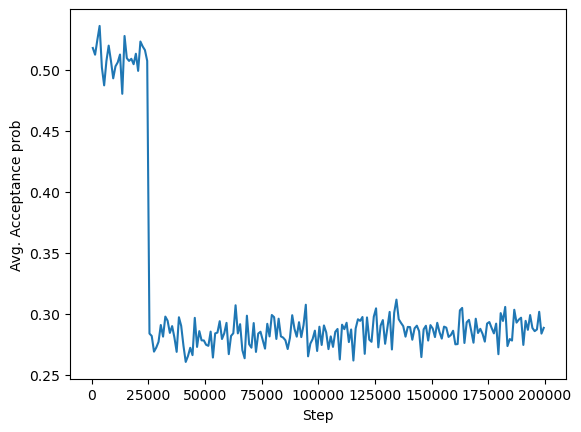

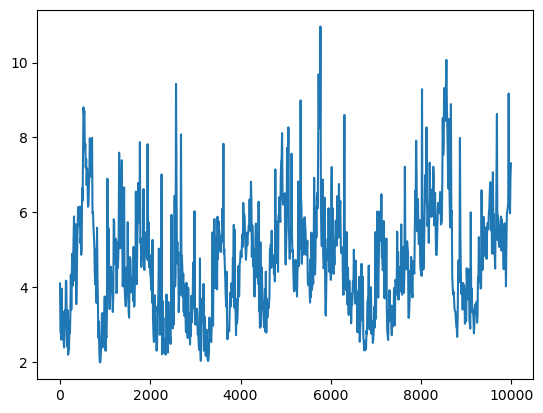

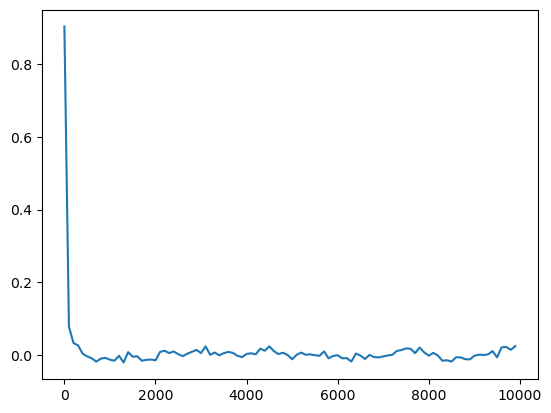

In [118]:
cd.plot_tprob_trace(navg=1000)
plt.show()
cd.plot_llh_trace()
plt.show()
cd.plot_llh_acf()
plt.show()

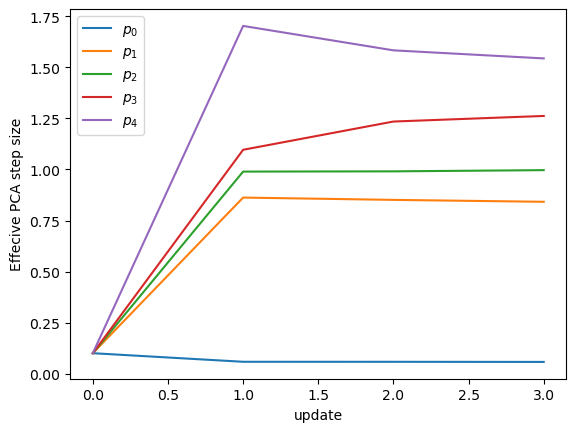

In [119]:
proposer.plot_step_sizes()

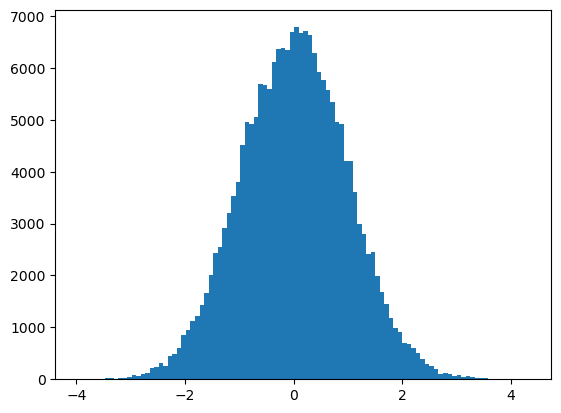

In [120]:
cd.plot_param(1)

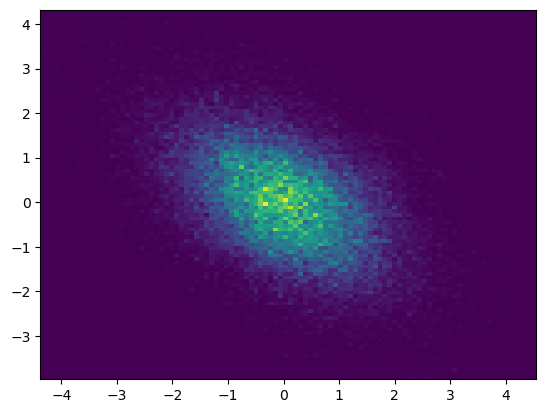

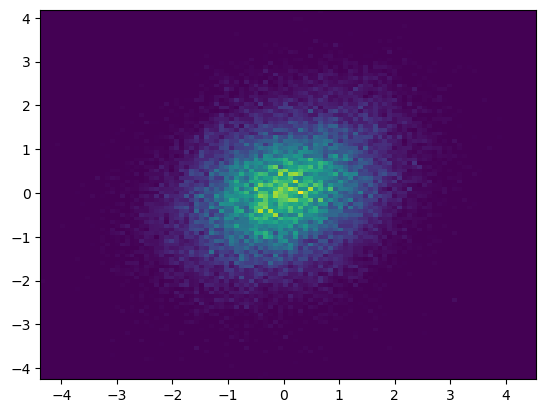

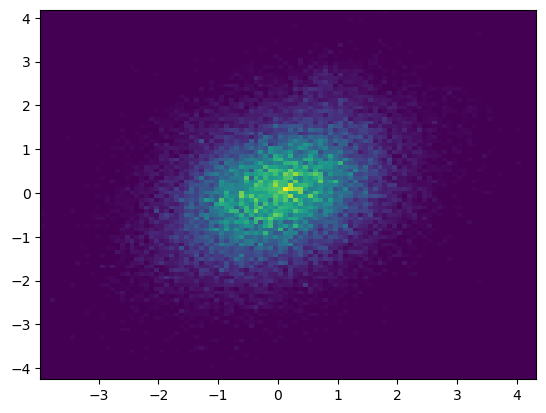

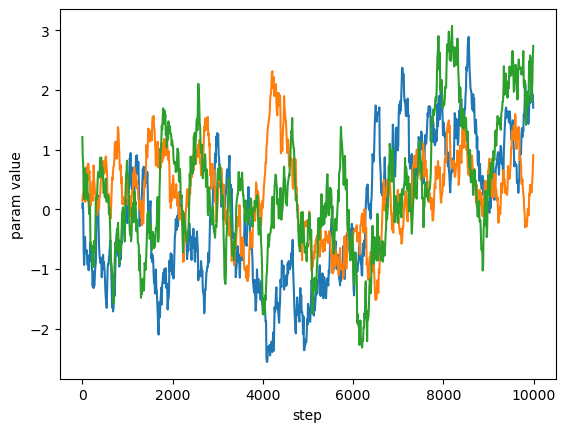

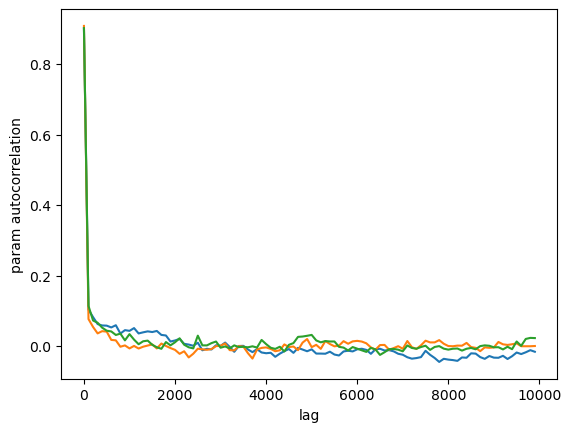

In [121]:
cd.plot_param2D(0, 1)
plt.show()
cd.plot_param2D(0, 2)
plt.show()
cd.plot_param2D(1, 2)
plt.show()

for i in range(3):
    cd.plot_param_trace(i)
plt.ylabel("param value")
plt.xlabel("step")
plt.show()

for i in range(3):
    cd.plot_param_acf(i)
plt.ylabel("param autocorrelation")
plt.xlabel("lag")
plt.show()

# Real Attempt

In [193]:
%%time

samples, proposer = metropolis_hastings(fnllh=myana.nllh, 
                             initial_state=np.random.normal(1,0.15, myana.nsyst),
                             step_size=0.1,
                             num_samples=100000,
                             update_ntimes=0, update_every=10000)

processed 10000/100000 steps in 1.2e+03s (1.2e+02 ms/st) with avg. acceptance prob: 0.35
processed 20000/100000 steps in 3e+02s (30 ms/st) with avg. acceptance prob: 0.35
processed 30000/100000 steps in 3e+02s (30 ms/st) with avg. acceptance prob: 0.36
processed 40000/100000 steps in 2.9e+02s (29 ms/st) with avg. acceptance prob: 0.36
processed 50000/100000 steps in 2.9e+02s (29 ms/st) with avg. acceptance prob: 0.35
processed 60000/100000 steps in 2.9e+02s (29 ms/st) with avg. acceptance prob: 0.35
processed 70000/100000 steps in 2.9e+02s (29 ms/st) with avg. acceptance prob: 0.35
processed 80000/100000 steps in 2.9e+02s (29 ms/st) with avg. acceptance prob: 0.35
processed 90000/100000 steps in 2.9e+02s (29 ms/st) with avg. acceptance prob: 0.36
CPU times: user 6h 43min 26s, sys: 1.84 s, total: 6h 43min 28s
Wall time: 1h 4min 3s


In [239]:
samples._offload_batch()

Wrote chain step batch to chain_0.pq


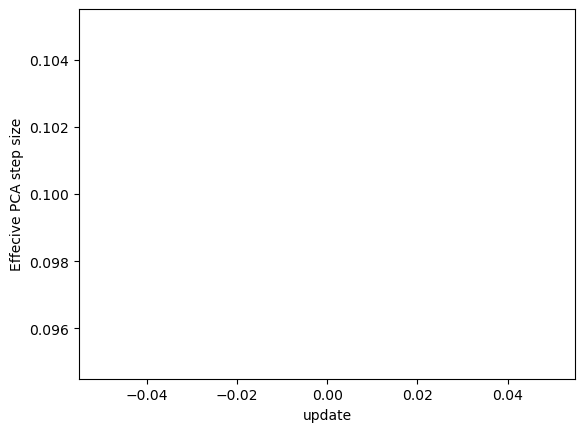

In [195]:
proposer.plot_step_sizes()

In [280]:
samples = Chain(filename_stub="chain_")
print(samples)
samples_adapt = Chain(filename_stub="adapt.chain_")
print(samples_adapt)


chain:
  nparams: 407
  nsteps: 100000
  nsteps on disk: 100000
  resident_capacity: 0
  nfiles: 1


chain:
  nparams: 407
  nsteps: 100000
  nsteps on disk: 100000
  resident_capacity: 0
  nfiles: 1



In [301]:
cdana = ChainDiagnostics(samples, burnin=50000)
cdana_adapt = ChainDiagnostics(samples_adapt, burnin=50000)

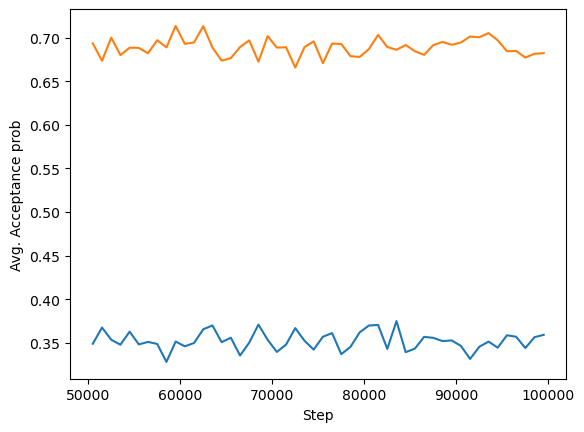

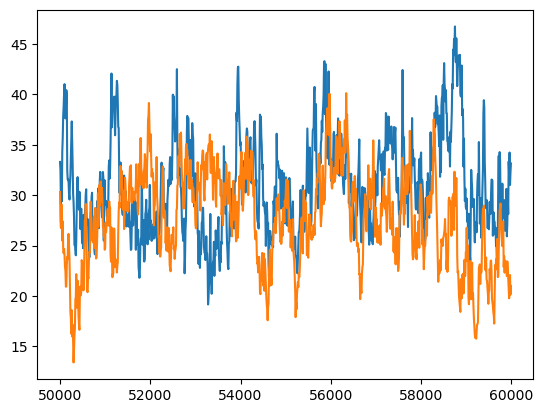

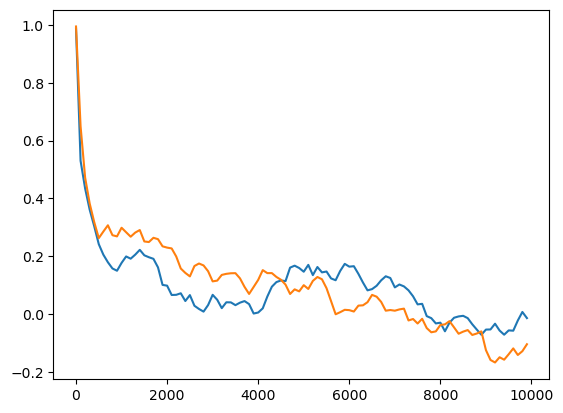

In [303]:
cdana.plot_tprob_trace(navg=1000)
cdana_adapt.plot_tprob_trace(navg=1000)
plt.show()
cdana.plot_llh_trace()
cdana_adapt.plot_llh_trace()
plt.show()
cdana.plot_llh_acf()
# cdana.plot_llh_acf()
cdana_adapt.plot_llh_acf()
plt.show()

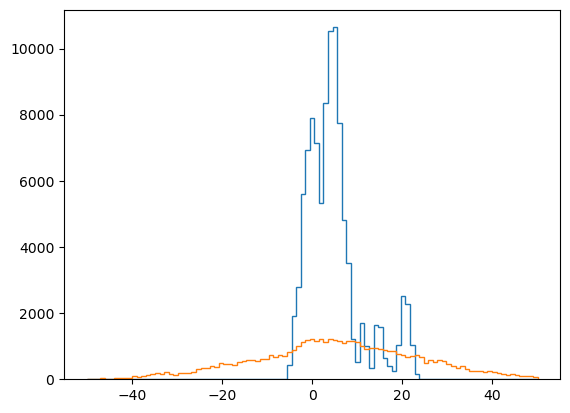

In [300]:
cdana.plot_param(5, bins=np.linspace(-50,50,100))
cdana_adapt.plot_param(5, bins=np.linspace(-50,50,100))

Calculating Covariance from in-memory state between entry 50000 to 100000 = 50000.


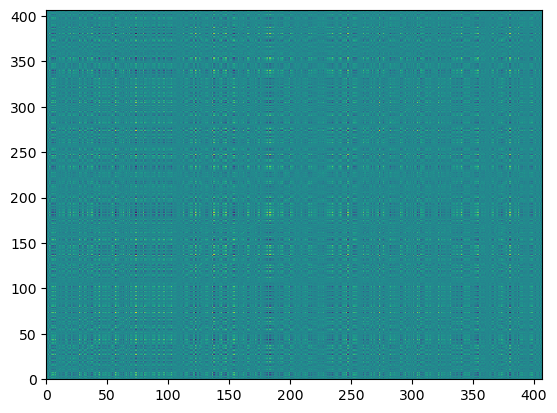

In [198]:
cdana.plot_covmat(burnin=50000)

In [182]:
v = np.diag(samples.cov(start=1000))

Calculating Covariance from in-memory state between entry 1000 to 100000 = 99000.


In [183]:
v

array([ 47.60571274, 344.80136675,  56.51547379, 121.40627584,
        69.56838315, 279.00799569,  78.02522015,  67.27437498,
       224.05344075, 112.11388819,  28.97216388, 204.5680997 ,
        37.37137543, 122.68227419, 146.56368699,  27.74180096,
        90.18371291, 113.5374591 ,  70.32654842, 165.55249109,
        30.91202163,  36.61414678, 134.85146859, 173.11504614,
       144.36968971,  34.46897066, 233.26664753, 106.95824884,
        37.48615414,  46.40855902,  55.91628949,  58.71968145,
        72.08853053,  74.03387175, 112.47622222,  58.82514106,
       101.02652015,  84.23237487,  55.06899579,  42.39830365,
       102.81434722,  24.3054949 ,  86.84228194,  54.25423472,
        62.69918873, 127.9612868 ,  72.17616114, 113.93909911,
       114.36015393,  30.76332661,  72.03925536, 150.93840473,
       107.77236268,  46.8108859 , 146.8285355 ,  61.73008777,
        52.4740958 ,  40.74381516,  18.81939048, 189.17407196,
        58.77355003, 489.29617565,  52.72544976, 253.96